In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

from utils import Pyutils as pyutils

plt.style.use("bmh")

SOURCE_PATH = os.getcwd()
INPUTS_PATH = os.path.join(SOURCE_PATH, "data", "inputs")
OUTPUTS_PATH = os.path.join(SOURCE_PATH, "data", "outputs")
DATASET_NAMES = ["betadgp_corrdgp_data", "betadgp_covdgp_data", "betadgp_beta2x2_data"]
TARGET_NAME = "betas_dgp"
MODEL_TAGS = ["linear_reg", "mlp"]

## 1) Aggregate all results

In [3]:
all_train_data = []
for ds in DATASET_NAMES:
    train_data = pd.read_csv(os.path.join(INPUTS_PATH, "simple_ar", ds + "_train.csv")).drop(["Var1", "Var2"], axis=1)
    train_data.columns = ["y", "x"]
    train_data["dataset"] = ds
    all_train_data.append(train_data)

all_train_data_df = pd.concat(all_train_data, axis=0)

In [4]:
all_data = []
model_summary = []
idx = 0
for model_tag in tqdm(MODEL_TAGS,
                      desc="Append all model results"):
    
    DGPS = os.listdir(os.path.join(OUTPUTS_PATH, model_tag))
    for dgp_name in DGPS:
        for ds in DATASET_NAMES:

            data = pd.read_csv(os.path.join(OUTPUTS_PATH, model_tag, dgp_name, ds + "_result.csv"))
            data["model"] = model_tag
            data["dgp"] = dgp_name
            data["dataset"] = ds
            
            mse = mean_squared_error(y_true=data["y"],
                                     y_pred=data["pred"])
            mae = mean_absolute_error(y_true=data["y"],
                                      y_pred=data["pred"])

            model_summary_tmp = pyutils.load_pkl(path=os.path.join(OUTPUTS_PATH, model_tag, dgp_name, ds + "_model.pickle"))
            model_summary_tmp["model"] = model_tag
            model_summary_tmp["dgp"] = dgp_name
            model_summary_tmp["dataset"] = ds
            model_summary_tmp["mse"] = mse
            model_summary_tmp["mae"] = mae
            if model_tag == "linear_reg":
                model_summary_tmp['coef'] = str(tuple(map(tuple, model_summary_tmp['coef']))[0])
            
            model_summary.append(pd.DataFrame(model_summary_tmp, index=[idx]))
            idx += 1
            
            all_data.append(data)
all_data_df = pd.concat(all_data, axis=0)
model_summary_df = pd.concat(model_summary, axis=0)

# aggregate relevant metrics
metrics_df = all_data_df.drop(["Var1", "Var2"], axis=1)
mse_group_df = metrics_df.groupby(["model", "dgp", "dataset"]).apply(pyutils.mse_melt).reset_index()
mae_group_df = metrics_df.groupby(["model", "dgp", "dataset"]).apply(pyutils.mae_melt).reset_index()

Append all model results: 100%|██████████| 2/2 [00:00<00:00, 33.60it/s]


### AR(1) betas as a function of the statistics

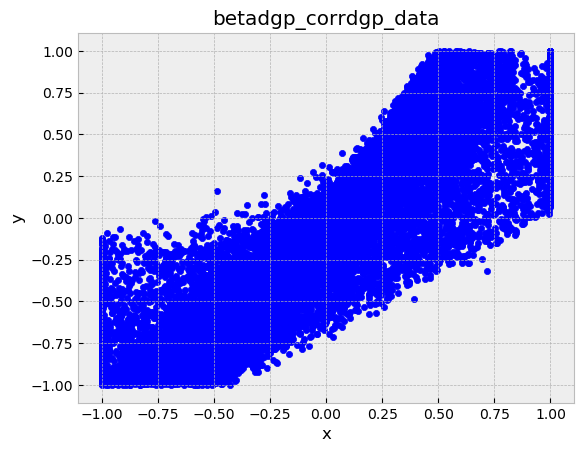

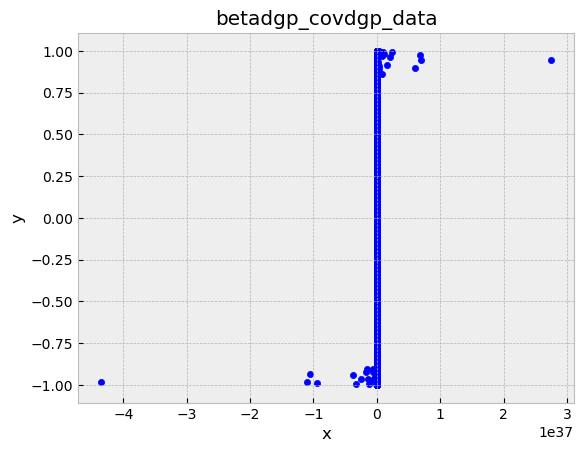

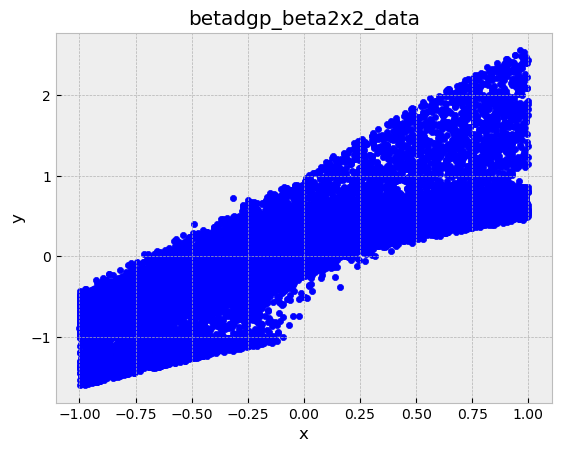

In [6]:
for ds in all_data_df["dataset"].unique():
    all_train_data_df.loc[all_train_data_df["dataset"] == ds].plot.scatter(y="y", x="x", title=ds)
    # plt.scatter(y=all_train_data_df.loc[all_train_data_df["dataset"] == ds]["y"], 
    #             x=all_train_data_df.loc[all_train_data_df["dataset"] == ds]["x"],
    #             alpha=0.5,
    #             label=ds)

### MSE histogram

Text(0.5, 1.0, 'MSE of the OOS forecast for each test simulation')

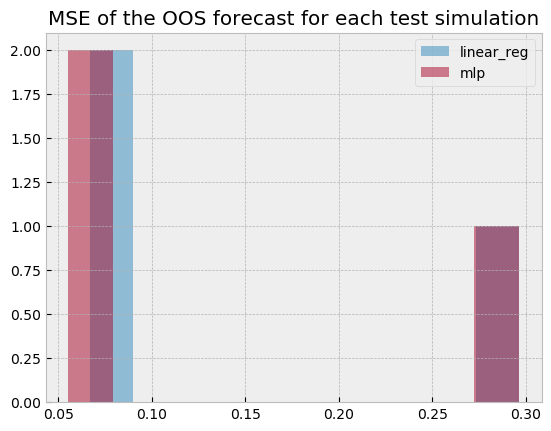

In [7]:
for model in mse_group_df["model"].unique():
    plt.hist(mse_group_df.loc[mse_group_df["model"] == model]["mse"], alpha=0.5, label=model)

plt.legend(loc='upper right')
plt.title("MSE of the OOS forecast for each test simulation")

### MAE histogram

Text(0.5, 1.0, 'MAE of the OOS forecast for each test simulation')

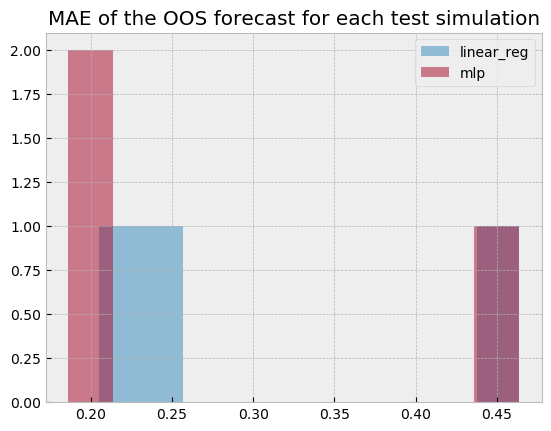

In [8]:
for model in mae_group_df["model"].unique():
    plt.hist(mae_group_df.loc[mae_group_df["model"] == model]["mae"], alpha=0.5, label=model)

plt.legend(loc='upper right')
plt.title("MAE of the OOS forecast for each test simulation")